In [1]:
import numpy as np
from sklearn.datasets import make_blobs

from helpers import plot_eigs, compute_K
from model import SSFS

np.random.seed(0)

In [2]:
def make_corr_noise(n_samples, n_features, block_size=50, seed=0):
    init_val = 0.01
    cov_matrix = np.ones((n_features, n_features)) * init_val

    np.fill_diagonal(cov_matrix, 1)
    num_blocks = n_features // block_size
    corr_block = 0.5

    for i in range(num_blocks):
        start_idx = i * block_size
        end_idx = (i + 1) * block_size
        cov_matrix[start_idx:end_idx, start_idx:end_idx] = corr_block
        np.fill_diagonal(cov_matrix[start_idx:end_idx, start_idx:end_idx], 1)

    correlated_noise = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov_matrix, size=n_samples)
    return correlated_noise

def make_noisy_corr_data(num_samples=200, num_fs=2, num_noisy_fs=100, block_size=15, seed=0):
    centers = 2
    cluster_std = 1
    X, y = make_blobs(n_samples=num_samples, centers=centers, n_features=num_fs, random_state=0, shuffle=True, cluster_std=cluster_std)
    X_noise = make_corr_noise(X.shape[0], num_noisy_fs, block_size)
    X = np.concatenate([X, X_noise], axis=1)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y

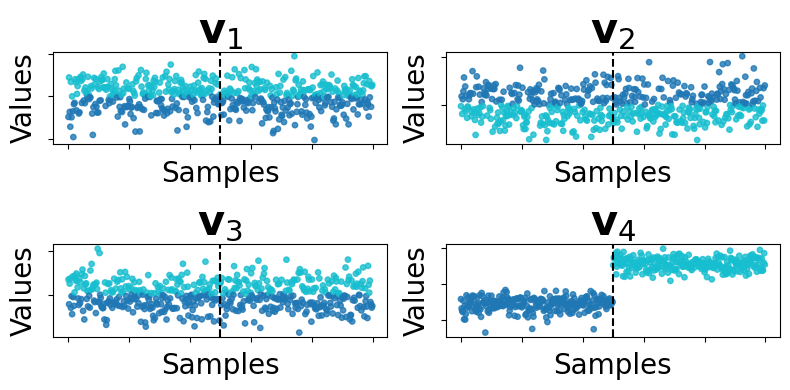

In [3]:
num_fs = 5
block_size = 15

num_samples = 500
num_noisy_fs = 45

X, y = make_noisy_corr_data(num_samples=num_samples, num_fs=num_fs, num_noisy_fs=num_noisy_fs, block_size=block_size)

idx = np.argsort(y)
X = X[idx]
y = y[idx]

plot_eigs(X, y)


In [4]:
# with xgboost
num_fs_select = 3

W = compute_K(X, 2)
n_clusters = len(np.unique(y))

args = {
    'num_clusters': n_clusters,
    'max_evrs': 2 * n_clusters,
    'W': W,
}

model = SSFS(**args)
model.fit(X)

s = model.get_scores()
idx = np.argsort(s)[::-1][:num_fs_select]
print("top selected features:", idx)

[+] selected eigenvectors: [3 2]
top selected features: [ 1  8 18]


In [5]:
# with a linear model
args = {
    'num_clusters': n_clusters,
    'max_evrs': 2 * n_clusters,
    'W': W,
    'model_fs': "linear_clf",
    's_type_fs': "coef"
}

model = SSFS(**args)
model.fit(X)

s = model.get_scores()
idx = np.argsort(s)[::-1][:num_fs_select]
print("top selected features:", idx)


[+] selected eigenvectors: [3 2]
top selected features: [3 2 1]
